# 5-number summary

This tutorial is meant to help to load, visualise and analyse datasets in order to prepare them for the data pre-processing

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#to save the plots to a pdf file
from matplotlib.backends.backend_pdf import PdfPages

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## General variables configuration

In [2]:
# dataset name and location
dataset_folder = './content/Bristol_owd.csv'

# results folder
res_folder = './content/'

# selecting the features and the time column
    # only the features related to the weather that are measurements are selected. That is, features that contains
    #  _id, _main, _description, and _icon are removed since they are use by open weather internally
    # the city name, lat, lon, and timezone can be safely removed since we have the files separated by city
    # we have two times format (dt and dt_iso). We select dt since it is the time in numeric format
fetures_to_preserve = ['temp', 'temp_min', 'temp_max', 'feels_like','pressure', 'humidity', 'wind_speed', 'wind_deg',
                       'clouds_all', 'Rain_id', 'Rain_main', 'Rain_description']

# features to ignore when performing the frequency counts
ignore_features = ['temp_min', 'temp_max']

######################################## Global variables ########################################
# original datasets
original_data = None

# datasets with the features of interest
new_dataset = None

# summary of nan values per feature
nan_summary = {}

# Give format to the features names as appears in the paper proposal
formated_features_names = []

## Functions

In [3]:
# Load all the datasets
def load_dataset():
  global original_data
  original_data = pd.read_csv(dataset_folder, sep=",", on_bad_lines='skip', dtype='str')


# Generate the new dataset
def build_new_dataset():
  global new_dataset
  global original_data
  #format the new structure of the data(dataframe)
  data_format = pd.DataFrame()
  # append the features previously selected (without the time column)
  data_format = original_data[fetures_to_preserve]
  # append the column time
  data_format.index = original_data['dt']
  new_dataset = data_format

# Compute a summary for all nan values per feature per dataset
def compute_nan_summary(dataset):
  global nan_summary
  print('Computing Nan summary')
  summary = {}
  for feature in list(dataset.columns):
      na_total = dataset[feature].isnull().sum()
      na_percentage = (na_total*100)/len(dataset.index)

      summary[feature] = [na_total, na_percentage]

  nan_summary = pd.DataFrame(summary, columns = list(dataset.columns), index = ['Na No', 'Na %'])

# Write the nan summary resutls as a Excel file
def write_nan_summary():
  with pd.ExcelWriter(res_folder + 'Nan_summary.xlsx') as writer:
    nan_summary.to_excel(writer, sheet_name='values')

# Plot the behaviour of the features across time
def plot_feats_across_time(dataset):
  print('Ploting features behaviour')

  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  plots_output = res_folder + 'features_across_time.pdf'
  #taking a look of the features variation across time
  plt.rcParams["figure.figsize"] = (20,30)
  dataset.plot(subplots=True)
  plt.savefig(plots_output)
  plt.close('all')

# Compute the 5-number summary
def five_number_summary(dataset):
  print('Computing the 5-number summary')

  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  with pd.ExcelWriter(res_folder + '5_number_summary.xlsx') as writer:
    #minimum
    dataset_min = dataset.min()
    #lower quartile
    dataset_lq = dataset.quantile(.25, axis = 0)
    #median
    dataset_med = dataset.median()
    #uper quartile
    dataset_uq = dataset.quantile(.75, axis = 0)
    #maximum
    dataset_max = dataset.max()

    summary = pd.concat([dataset_min.rename("Min"), 
                    dataset_lq.rename("Lower quartile"),
                    dataset_med.rename("Median"),
                    dataset_uq.rename("Uper quartile"),
                    dataset_max.rename("Max")], axis=1)

    summary.to_excel(writer, sheet_name='values')

# Plot boxplots and histograms per feature
def plot_boxplots_histograms(dataset):
  print('Ploting boxplots and histograms')
  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  plots_output = res_folder + 'box_plots_&_histograms.pdf'
  pdf = PdfPages(plots_output)

  plt.rcParams["figure.figsize"] = (20,8)

  for feature in list(dataset.columns):
      fig, axes = plt.subplots(1, 2)
      dataset.boxplot(column=feature, ax=axes[0])
      dataset.hist(column=feature, ax=axes[1])
      pdf.savefig(fig)

  pdf.close()
  plt.close('all')

# Plot all histograms of all features per dataset together
def plot_histograms(dataset):
  print('Ploting histograms')
  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  plots_output = res_folder + 'all_histograms.pdf'
  plt.rcParams["figure.figsize"] = (20,15)
  dataset.hist()
  plt.savefig(plots_output)
  plt.close('all')

# Compute the frequency counts per feature per dataset
# Compute the frequency counts per feature per dataset
def freq_counts(dataset):
    print('Computing frequency counts')

    with pd.ExcelWriter(res_folder + 'frequency_counts.xlsx') as writer:
        # Create a visible sheet with the first row of the dataset
        dataset.iloc[:1].to_excel(writer, sheet_name='Sheet1', index=False)

        # Transform each column type of the dataset to numeric (float) to perform the analysis
        dataset = dataset.iloc[:, :-3].astype(float)

        for feature in list(dataset.columns):
            if feature not in ignore_features:
                min_val = dataset[feature].min()
                max_val = dataset[feature].max()

                if isinstance(min_val, float):
                    min_val = np.round(min_val, 0).astype(int)

                if isinstance(max_val, float):
                    max_val = np.round(max_val, 0).astype(int)

                ranges = []
                for i in range(min_val, max_val + 2):
                    ranges.append(i)

                temp_feat_df = dataset[feature]
                counts = temp_feat_df.groupby(pd.cut(temp_feat_df, ranges)).count()

                counts.to_excel(writer, sheet_name=feature)

# Generate all the analysis plots
def analysis_plots(dataset):
    # revise for NaN values
    compute_nan_summary(dataset)
    
    # write nan summary results for each dataset/city
    write_nan_summary()
    
    # generate the plots to see features behaviour across time
    plot_feats_across_time(dataset)
    
    # generate the 5-number summary
    five_number_summary(dataset)

    # plot the boxplots and histograms
    plot_boxplots_histograms(dataset)

    # plot the histograms together
    plot_histograms(dataset)
    
    # compute the frequency counts
    freq_counts(dataset)

# Plot nullness/nans percentages of the features in a dataset
def plot_nullness():
  global nan_summary

  plt.rcParams['axes.labelsize'] = 13
  plt.rcParams['axes.labelweight'] = 'bold'
  
  plots_output = res_folder + 'nullness.pdf'
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,25), dpi= 80)
  fig.subplots_adjust(hspace=.07, wspace=.05)
  
  ax.scatter(y=nan_summary.columns, x=nan_summary.iloc[1,:], color='purple', alpha=1)
  ax.set_xlabel('Nullness %')
  ax.set_yticks(nan_summary.columns)
  ax.set_yticklabels(nan_summary.columns, fontdict={'horizontalalignment': 'right'}, size = 13, weight = 'bold' )
  ax.set_xlim(-5, 105)
  ax.grid(True)
  ax.set_axisbelow(True)
  ax.set_title('Bristol', size = 16, weight = 'bold')

  plt.tight_layout()
  plt.show()
  fig.savefig(plots_output)

## Load the dataset and visualise it

In [4]:
load_dataset()

In [5]:
# get a quick view of Bristol data
original_data.head()

,city_name,lat,lon,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,...,Dust_description,Dust_icon,Tornado_id,Tornado_main,Tornado_description,Tornado_icon,Squall_id,Squall_main,Squall_description,Squall_icon
0,Bristol,51.454513,-2.58791,47.95,46.4,49.82,45.07,1020,92,3.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bristol,51.454513,-2.58791,48.09,46.22,50,43.56,1021,97,6.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bristol,51.454513,-2.58791,48.15,46.04,49.82,44.19,1021,96,5.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bristol,51.454513,-2.58791,48.18,46.22,49.82,43.61,1021,96,6.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bristol,51.454513,-2.58791,47.64,45.89,49.28,45.01,1022,97,3.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
original_data['dt_iso']

0         2000-01-01 00:00:00 +0000 UTC
1         2000-01-01 01:00:00 +0000 UTC
2         2000-01-01 02:00:00 +0000 UTC
3         2000-01-01 03:00:00 +0000 UTC
4         2000-01-01 04:00:00 +0000 UTC
                      ...              
178003    2020-04-21 19:00:00 +0000 UTC
178004    2020-04-21 20:00:00 +0000 UTC
178005    2020-04-21 21:00:00 +0000 UTC
178006    2020-04-21 22:00:00 +0000 UTC
178007    2020-04-21 23:00:00 +0000 UTC
Name: dt_iso, Length: 178008, dtype: object

In [7]:
#see the name of the columns
original_data.columns

Index(['city_name', 'lat', 'lon', 'temp', 'temp_min', 'temp_max', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'dt',
       'dt_iso', 'timezone', 'Rain_id', 'Rain_main', 'Rain_description',
       'Rain_icon', 'Drizzle_id', 'Drizzle_main', 'Drizzle_description',
       'Drizzle_icon', 'Fog_id', 'Fog_main', 'Fog_description', 'Fog_icon',
       'Clouds_id', 'Clouds_main', 'Clouds_description', 'Clouds_icon',
       'Haze_id', 'Haze_main', 'Haze_description', 'Haze_icon', 'Mist_id',
       'Mist_main', 'Mist_description', 'Mist_icon', 'Clear_id', 'Clear_main',
       'Clear_description', 'Clear_icon', 'Snow_id', 'Snow_main',
       'Snow_description', 'Snow_icon', 'Thunderstorm_id', 'Thunderstorm_main',
       'Thunderstorm_description', 'Thunderstorm_icon', 'Smoke_id',
       'Smoke_main', 'Smoke_description', 'Smoke_icon', 'Dust_id', 'Dust_main',
       'Dust_description', 'Dust_icon', 'Tornado_id', 'Tornado_main',
       'Tornado_description', '

## Data pre-processing

In [8]:
# Generate the new dataset
build_new_dataset()

In [9]:
# view the dataset processed
new_dataset.head()

,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,clouds_all,Rain_id,Rain_main,Rain_description
dt,,,,,,,,,,,,
946684800,47.95,46.4,49.82,45.07,1020,92,3.36,230,40,NaN,NaN,NaN
946688400,48.09,46.22,50,43.56,1021,97,6.93,250,20,NaN,NaN,NaN
946692000,48.15,46.04,49.82,44.19,1021,96,5.82,240,40,NaN,NaN,NaN
946695600,48.18,46.22,49.82,43.61,1021,96,6.93,240,40,NaN,NaN,NaN
946699200,47.64,45.89,49.28,45.01,1022,97,3.36,270,40,NaN,NaN,NaN


In [10]:
# Perform all the analysis
analysis_plots(new_dataset)

Computing Nan summary
Ploting features behaviour
Computing the 5-number summary
Ploting boxplots and histograms
Ploting histograms
Computing frequency counts


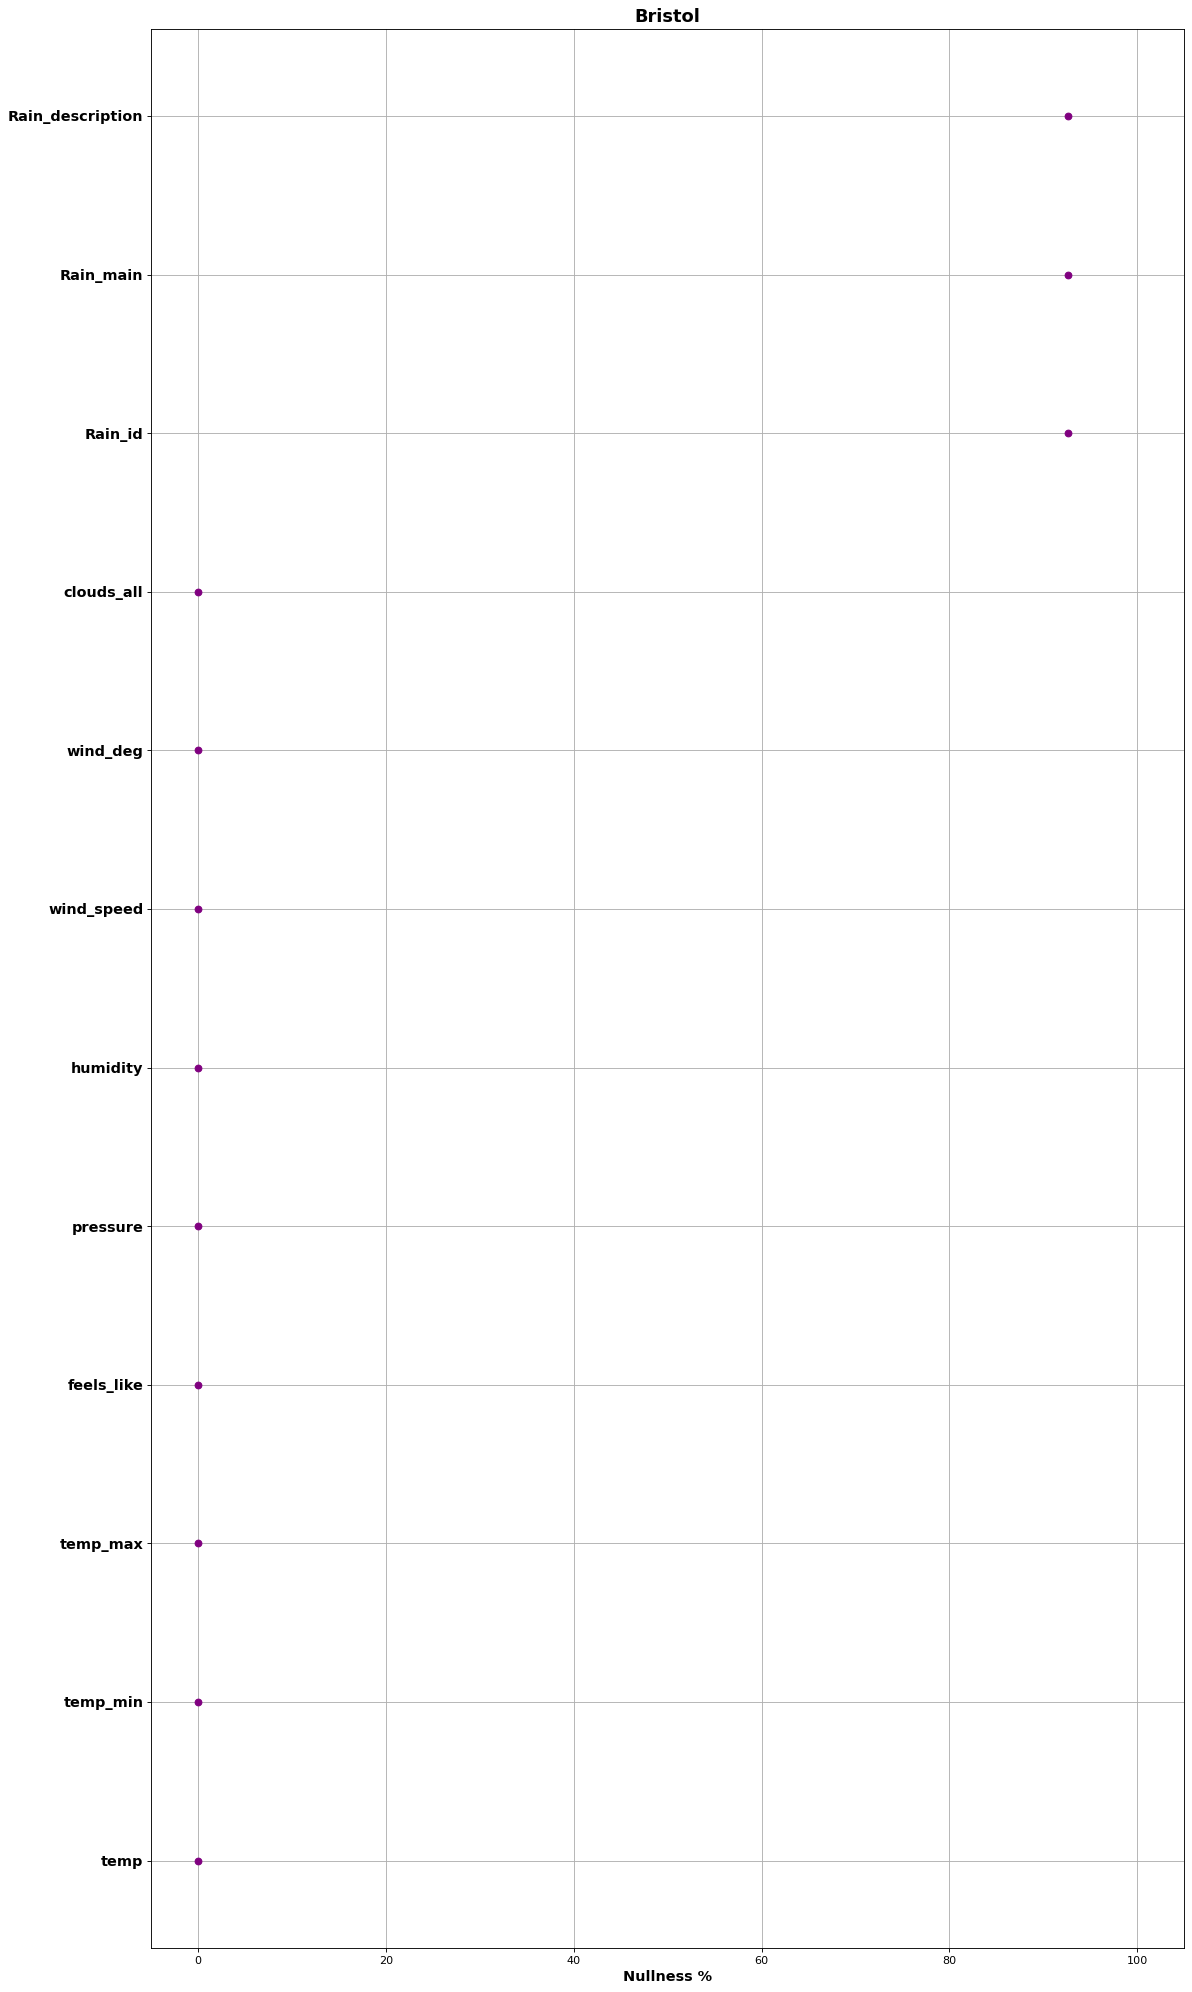

In [11]:
# Plot features nullness(nans)
plot_nullness()

### 1) Replace missing values with the average (mean) of the respective column

### For categorical columns, you might want to use the mode (the most frequent value) instead:

### 2) Replace missing values with the nearest non-null value

### 3) Remove all rows that contain at least one NaN value

Then, you can call the analysis_plots function for each approach and draw conclusions based on the results.

As for the conclusion, it will depend on the results you get from the analysis_plots function and your specific use case. Generally, if the data is not missing at random, it might be better to use an approach like filling with the mean or mode or forward filling. If the data is missing randomly and the percentage of missing data is small, you may opt for dropping the rows with missing values.

Remember to make a copy of your DataFrame before applying each approach, so you can compare the results at the end.

In [14]:
columnas = ['Rain_id', 'Rain_main', 'Rain_description']

# 1) Completar los valores de las celdas faltantes con el valor promedio de los registros respectivos de su columna
def reemplazar_con_promedio(dataset, columnas):
    dataset_copy = dataset.copy()
    for columna in columnas:
        if dataset_copy[columna].dtype in [np.float64, np.int64]:
            valor_promedio = dataset_copy[columna].mean()
            dataset_copy[columna].fillna(valor_promedio, inplace=True)
            dataset_copy[columna] = dataset_copy[columna].astype(dataset[columna].dtype)
    return dataset_copy

new_dataset_promedio = reemplazar_con_promedio(new_dataset, columnas)
print("Reemplazando por media")
print(new_dataset_promedio)
print("====================")

# Para las columnas categóricas, es posible que desee utilizar la moda (el valor más frecuente):
def reemplazar_con_moda(dataset, columnas):
    dataset_copy = dataset.copy()
    for columna in columnas:
        if dataset_copy[columna].dtype == object:
            valor_moda = dataset_copy[columna].mode()[0]
            dataset_copy[columna].fillna(valor_moda, inplace=True)
    return dataset_copy

new_dataset_moda = reemplazar_con_moda(new_dataset, columnas)
print("Reemplazando por moda")
print(new_dataset_moda)
print("====================")

# 2) Completar los valores de las celdas faltantes con el valor de la celda más cercana de su respectiva columna
def reemplazar_con_cercano(dataset, columnas):
    dataset_copy = dataset.copy()
    for columna in columnas:
        dataset_copy[columna].fillna(method='ffill', inplace=True)
    return dataset_copy

new_dataset_cercano = reemplazar_con_cercano(new_dataset, columnas)
print("Reemplazando por cercano")
print(new_dataset_cercano)
print("====================")

# 3) Eliminar todos los registros/observaciones que presente al menos un valor NaN en cualquiera de las características/columnas
def eliminar_filas_nan(dataset, columnas):
    dataset_copy = dataset.copy()
    dataset_copy.dropna(subset=columnas, inplace=True)
    return dataset_copy

new_dataset_sin_nan = eliminar_filas_nan(new_dataset, columnas)
print("Reemplazando nulos")
print(new_dataset_sin_nan)
print("====================")

Reemplazando por media
             temp temp_min temp_max feels_like pressure humidity wind_speed  \
dt                                                                            
946684800   47.95     46.4    49.82      45.07     1020       92       3.36   
946688400   48.09    46.22       50      43.56     1021       97       6.93   
946692000   48.15    46.04    49.82      44.19     1021       96       5.82   
946695600   48.18    46.22    49.82      43.61     1021       96       6.93   
946699200   47.64    45.89    49.28      45.01     1022       97       3.36   
...           ...      ...      ...        ...      ...      ...        ...   
1587495600  59.31    54.41     62.6      45.97     1016       41      18.34   
1587499200  55.29    46.32       59      42.55     1017       47      17.22   
1587502800  53.74    48.24     57.2      39.76     1017       50      19.46   
1587506400  52.03    48.24     55.4      39.61     1018       57      17.22   
1587510000   49.6    43.97   